---
title: "Multiple Outputs"
format:
  html:
    code-fold: true
jupyter: python3
author: "kakamana"
date: "2023-04-08"
categories: [python, datacamp, machine learning, deep learning, tensorflow, keraas, neural network]
image: "multipleOutputs-1"

---

# Multiple Outputs

You will build neural networks with multiple outputs in this chapter, which can be used to solve regression problems with multiple targets. Additionally, you will build a model that simultaneously solves a regression problem and a classification problem.

This **Multiple Outputs** is part of [Datacamp course: Advanced Deep Learning with Keras] You will learn how to use the versatile Keras functional API to solve a variety of problems. The course will begin with simple, multi-layer dense networks (also known as multi-layer perceptrons) and progress to more sophisticated architectures. This course will cover how to construct models with multiple inputs and a single output, as well as how to share weights between layers in a model. Additionally, we will discuss advanced topics such as category embeddings and multiple output networks. This course will teach you how to train a network that performs both classification and regression.

This is my learning experience of data science through DataCamp. These repository contributions are part of my learning journey through my graduate program masters of applied data sciences (MADS) at University Of Michigan, [DeepLearning.AI], [Coursera] & [DataCamp]. You can find my similar articles & more stories at my [medium] & [LinkedIn] profile. I am available at [kaggle] & [github blogs] & [github repos]. Thank you for your motivation, support & valuable feedback.

These include projects, coursework & notebook which I learned through my data science journey. They are created for reproducible & future reference purpose only. All source code, slides or screenshot are intellactual property of respective content authors. If you find these contents beneficial, kindly consider learning subscription from [DeepLearning.AI Subscription], [Coursera], [DataCamp]



[DeepLearning.AI]: https://www.deeplearning.ai
[DeepLearning.AI Subscription]: https://www.deeplearning.ai
[Coursera]: https://www.coursera.org
[DataCamp]: https://www.datacamp.com
[medium]: https://medium.com/@kamig4u
[LinkedIn]: https://www.linkedin.com/in/asadenterprisearchitect
[kaggle]: https://www.kaggle.com/kakamana
[github blogs]: https://kakamana.github.io
[github repos]: https://github.com/kakamana
[Datacamp course: Introduction to Natural Language Processing in Python]: (https://app.datacamp.com/learn/courses/advanced-deep-learning-with-keras)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 8)

# Two-output models
## Simple two-output model
In this exercise, you will use the tournament data to build one model that makes two predictions: the scores of both teams in a given game. Your inputs will be the seed difference of the two teams, as well as the predicted score difference from the model you built in chapter 3.

The output from your model will be the predicted score for team 1 as well as team 2. This is called "multiple target regression": one model making more than one prediction

In [2]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the input
input_tensor = Input(shape=(2, ))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

Metal device set to: Apple M2 Pro


## Fit a model with two outputs
Now that you've defined your 2-output model, fit it to the tournament data. I've split the data into games_tourney_train and games_tourney_test, so use the training set to fit for now.

This model will use the pre-tournament seeds, as well as your pre-tournament predictions from the regular season model you built previously in this course.

As a reminder, this model will predict the scores of both teams.

In [3]:
games_tourney = pd.read_csv('dataset/games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [4]:
games_season = pd.read_csv('dataset/games_season.csv')
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [5]:
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

# Count the unique number of teams
n_teams = np.unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

# Create an input layer for the team ID
teamid_in = Input(shape=(1, ))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

# Create an Input for each team
team_in_1 = Input(shape=(1, ), name='Team-1-In')
team_in_2 = Input(shape=(1, ), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1, ), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer,
# then add a Dense layer

out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

# Make a model
p_model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
p_model.compile(optimizer='adam', loss='mean_absolute_error')

# Fit the model to the games_season dataset
p_model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1, verbose=True, validation_split=0.1, batch_size=2048)

games_tourney['pred'] = p_model.predict([games_tourney['team_1'],
                                       games_tourney['team_2'],
                                       games_tourney['home']])

2023-04-08 01:04:42.790937: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


133/133 [==============================] - 0s 2ms/step


In [6]:
games_tourney_train = games_tourney[games_tourney['season'] <= 2010]
games_tourney_test = games_tourney[games_tourney['season'] > 2010]

In [7]:
model.fit(games_tourney_train[['seed_diff', 'pred']],
          games_tourney_train[['score_1', 'score_2']],
          verbose=False,
          epochs=10000,
          batch_size=256);

## Inspect the model (I)
Now that you've fit your model, let's take a look at it. You can use the .get_weights() method to inspect your model's weights.

The input layer will have 4 weights: 2 for each input times 2 for each output.

The output layer will have 2 weights, one for each output.

In [8]:
# Print the model's weights
print(model.get_weights())

# Print the column means of the training data
print(games_tourney_train.mean())

[array([[ 0.57821244, -0.66847074],
       [23.578228  , 21.29037   ]], dtype=float32), array([67.67261, 68.08015], dtype=float32)]
season        1997.548544
team_1        5560.890777
team_2        5560.890777
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.786711
score_2         71.786711
won              0.500000
pred             0.141091
dtype: float64


## Evaluate the model
Now that you've fit your model and inspected it's weights to make sure it makes sense, evaluate it on the tournament test set to see how well it performs on new data.

In [9]:
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
                     games_tourney_test[['score_1', 'score_2']],
                     verbose=False))

8.862776756286621


# Single model for classification and regression

## Classification and regression in one model
Now you will create a different kind of 2-output model. This time, you will predict the score difference, instead of both team's scores and then you will predict the probability that team 1 won the game. This is a pretty cool model: it is going to do both classification and regression!

In this model, turn off the bias, or intercept for each layer. Your inputs (seed difference and predicted score difference) have a mean of very close to zero, and your outputs both have means that are close to zero, so your model shouldn't need the bias term to fit the data well.

In [10]:
input_tensor = Input(shape=(2, ))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output(use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

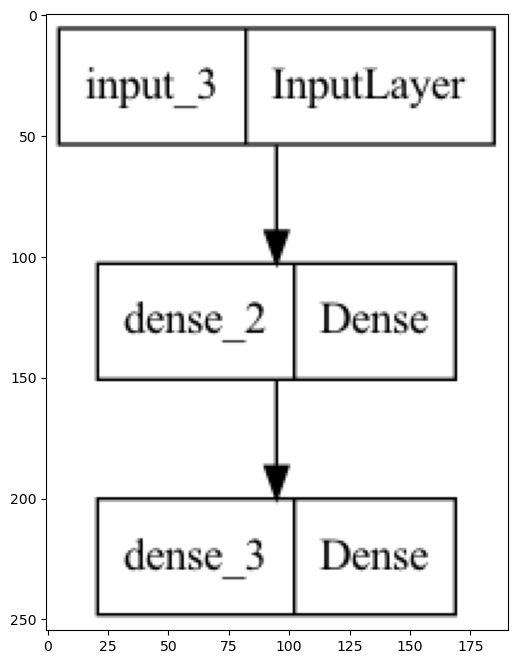

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='Images/multi_output_model.png')

data = plt.imread('Images/multi_output_model.png')
plt.imshow(data);

## Compile and fit the model
Now that you have a model with 2 outputs, compile it with 2 loss functions: mean absolute error (MAE) for 'score_diff' and binary cross-entropy (also known as logloss) for 'won'. Then fit the model with 'seed_diff' and 'pred' as inputs. For outputs, predict 'score_diff' and 'won'.

This model can use the scores of the games to make sure that close games (small score diff) have lower win probabilities than blowouts (large score diff).

The regression problem is easier than the classification problem because MAE punishes the model less for a loss due to random chance. For example, if score_diff is -1 and won is 0, that means team_1 had some bad luck and lost by a single free throw. The data for the easy problem helps the model find a solution to the hard problem.

In [12]:
from tensorflow.keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimizer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(lr=0.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=20,
          verbose=True,
          batch_size=16384);

Epoch 1/20
1/1 [==============================] - 1s 832ms/step - loss: 11.3476 - dense_2_loss: 10.6665 - dense_3_loss: 0.6811
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: 11.3453 - dense_2_loss: 10.6633 - dense_3_loss: 0.6820
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 11.3429 - dense_2_loss: 10.6601 - dense_3_loss: 0.6828
Epoch 4/20
1/1 [==============================] - 0s 12ms/step - loss: 11.3406 - dense_2_loss: 10.6569 - dense_3_loss: 0.6837
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 11.3382 - dense_2_loss: 10.6537 - dense_3_loss: 0.6846
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 11.3359 - dense_2_loss: 10.6504 - dense_3_loss: 0.6855
Epoch 7/20
1/1 [==============================] - 0s 9ms/step - loss: 11.3336 - dense_2_loss: 10.6472 - dense_3_loss: 0.6863
Epoch 8/20
1/1 [==============================] - 0s 12ms/step - loss: 11.3312 - dense_2_loss: 10.6440 - dense_3_loss:

## Inspect the model (II)
Now you should take a look at the weights for this model. In particular, note the last weight of the model. This weight converts the predicted score difference to a predicted win probability. If you multiply the predicted score difference by the last weight of the model and then apply the sigmoid function, you get the win probability of the game.

In [13]:
# Print the model weights
print(model.get_weights())

# Print the training data means
print(games_tourney_train.mean())

[array([[ 0.33446303],
       [-1.1826252 ]], dtype=float32), array([[1.3517005]], dtype=float32)]
season        1997.548544
team_1        5560.890777
team_2        5560.890777
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.786711
score_2         71.786711
won              0.500000
pred             0.141091
dtype: float64


In [14]:
from scipy.special import expit as sigmoid

# Weight from the model
weight=0.14

# Print the approximate win probability predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability predicted blowout game
print(sigmoid(10 * weight))

0.5349429451582145
0.8021838885585818


## Evaluate on new data with two metrics
Now that you've fit your model and inspected its weights to make sure they make sense, evaluate your model on the tournament test set to see how well it does on new data.

Note that in this case, Keras will return 3 numbers: the first number will be the sum of both the loss functions, and then the next 2 numbers will be the loss functions you used when defining the model.

In [15]:
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
                    [games_tourney_test[['score_diff']], games_tourney_test[['won']]],
                     verbose=False))


[11.036083221435547, 10.24341106414795, 0.7926721572875977]
